## Let's make a simple neural predictor

In [1]:
import tensorflow as tf
import json
import numpy as np
import matplotlib.pyplot as plt

In [2]:
with open("../history.json",'r') as f:
    data = json.load(f)

In [3]:
def process_data(data):
    vec = []
    for d in data.values():
        vec.append(d['value'])
    D = np.dstack(np.array(vec))[0]
    for i in range(len(data)):
        cD = D[:,i]
        D[:,i] = (cD-cD.mean())/cD.std()
    return D
    

In [4]:
D = process_data(data)

In [5]:
class DataGenerator(tf.keras.utils.Sequence):
    def __init__(self,time_series_data,batch_size=32,input_window_width=5,output_window_width = 1,test_prop=.9):
        self.batch_size = batch_size
        
        self.time_series_data = process_data(time_series_data)
        end_train_index = int(len(self.time_series_data)*test_prop)
        self.train_data = self.time_series_data[:end_train_index]
        self.test_data = self.time_series_data[end_train_index:]
        
        self.input_window_width = input_window_width
        self.output_window_width = output_window_width
        self.n = 0
        self.mode = "train"
        self.random_channel = -1
    def __getitem__(self,index):
        features = []
        labels = []
        if self.mode=="train":
            time_series_data= self.train_data
        else:
            time_series_data = self.test_data
        
        L = len(self)
        
        if index<0:
            index = len(self)+index
        for i in range(self.batch_size):
            if index+i>L:
                break
            features.append(time_series_data[index+i:index+i+self.input_window_width])
            start_index = index+i+self.input_window_width
            end_index = index+i+self.input_window_width+self.output_window_width
            labels.append(time_series_data[start_index:end_index])   
        features = np.array(features)
        labels = np.array(labels)
        if self.random_channel!=-1:
            features[:,:,self.random_channel] = np.random.randn(*features[:,:,self.random_channel].shape)
            
        return features,labels
    def __len__(self):
        if self.mode=="train":
            time_series_data = self.train_data
        else:
            time_series_data = self.test_data
        return max(0,len(time_series_data[:-self.output_window_width])-self.input_window_width)
    
    def __iter__(self):
        self.n +=1
        return self[self.n]
    
    def __next__(self):
        self.n +=1
        return self[self.n]
        
    def get_one(self,index):
        if self.mode=="train":
            time_series_data=self.train_data
        else:
            time_series_data = self.test_data
        features = tf.expand_dims(time_series_data[index:index+self.input_window_width],axis=0)
        labels = tf.expand_dims(time_series_data[index+self.input_window_width:index+self.input_window_width+self.output_window_width],axis=0)
        return features,labels
    
    def on_epoch_end(self):
        self.n=0
        

In [6]:
data_generator = DataGenerator(data,test_prop=.6)

In [7]:
for d in data_generator:
    print("a")
    break

TypeError: iter() returned non-iterator of type 'tuple'

In [8]:
num_steps_input = 5
num_steps_output = 1
model_input = tf.keras.Input(shape=(5,4))

y = tf.keras.layers.Flatten()(model_input)
y = tf.keras.layers.Dense(10)(y)
y = tf.keras.layers.Dense(4*num_steps_output)(y)
y = tf.keras.layers.Reshape((num_steps_output,4))(y)

model = tf.keras.Model(inputs = model_input,outputs = y)



2021-09-03 13:49:13.589296: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [9]:
model.compile(loss="MSE")

A = model.fit_generator(data_generator)

/Users/galois/.pyenv/versions/3.7.9/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1940: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '
2021-09-03 13:49:15.314046: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)


2994/2994 [==============================] - 4s 1ms/step - loss: 0.2578


/Users/galois/.pyenv/versions/3.7.9/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:2001: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


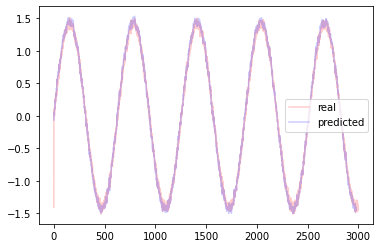

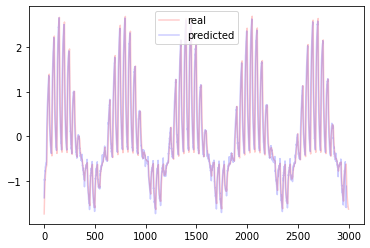

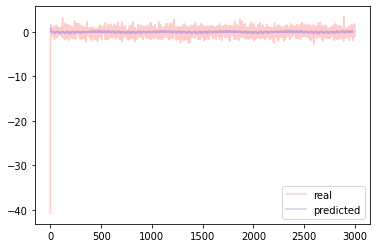

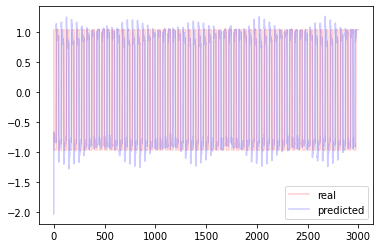

In [10]:
data_generator.mode="train"
A = model.predict_generator(data_generator)
L = len(data_generator)
up_to=3000
for i in range(4):
    
    plt.plot(D[:up_to][:,i],c="r",alpha=.2,label="real")
    plt.plot(A[:,:,i][::32][:up_to],c="b",alpha=.2,label="predicted")
    plt.legend()
    plt.show()

In [11]:
data_generator.mode="test"
A = model.predict_generator(data_generator)

/Users/galois/.pyenv/versions/3.7.9/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:2001: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


In [12]:
D = process_data(data)

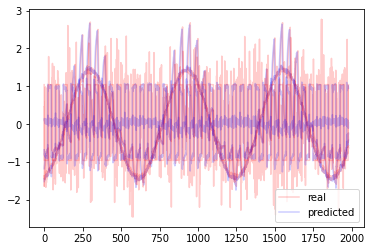

In [13]:
data_generator.mode="test"
L = len(data_generator)
for i in range(4):
    if i==0:
        plt.plot(D[-L-6:-20][:,i],c="r",alpha=.2,label="real")
        plt.plot(A[:,:,i][::32],c="b",alpha=.2,label="predicted")
    else:
        plt.plot(D[-L-6:-20][:,i],c="r",alpha=.2)
        plt.plot(A[:,:,i][::32],c="b",alpha=.2)
plt.legend()

No handles with labels found to put in legend.


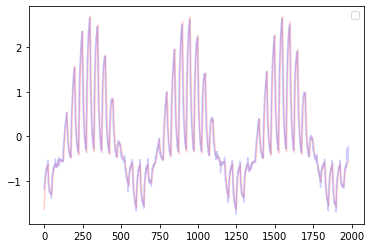

In [14]:
I = 1
for i in range(I,I+1):
    if i==0:
        plt.plot(D[-L-6:-20][:,i],c="r",alpha=.2,label="real")
        plt.plot(A[:,:,i][::32],c="b",alpha=.2,label="predicted")
    else:
        plt.plot(D[-L-6:-20][:,i],c="r",alpha=.2)
        plt.plot(A[:,:,i][::32],c="b",alpha=.2)
plt.legend()

## From here let's try to figure out what affected what

In [15]:
keys = list(data.keys())

In [16]:
for i in range(-1,4):
    if i == -1:
        print("No degradation")
    else:
        print("Degradation on {}".format(keys[i]))
    data_generator.random_channel= i

    loss = model.evaluate_generator(data_generator)
    print("Score(lower is better): {}".format(loss))

No degradation


/Users/galois/.pyenv/versions/3.7.9/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1973: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


Score(lower is better): 0.21000608801841736
Degradation on T1
Score(lower is better): 0.7272300720214844
Degradation on T2
Score(lower is better): 0.878957986831665
Degradation on T3
Score(lower is better): 0.21031972765922546
Degradation on V1
Score(lower is better): 0.6527882218360901


## So clearly T3 seems to not be affecting the outcome while T1,V1, and T2 are certainly being affected by a degradation of the signal

### from this model we can pull out probability distributions

In [17]:
random_input = np.random.randn(1000,5,4)

In [18]:
random_output = model.predict_generator(random_input)

/Users/galois/.pyenv/versions/3.7.9/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:2001: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


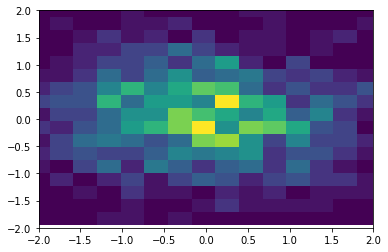

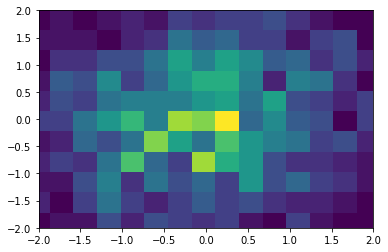

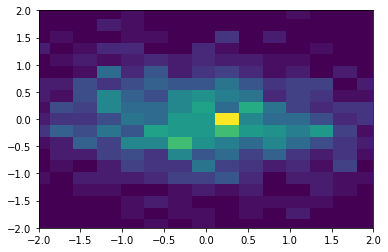

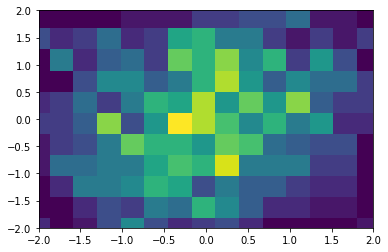

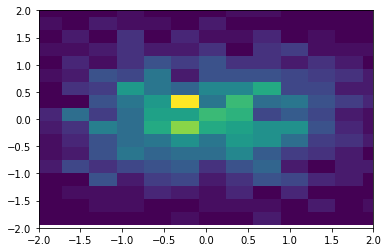

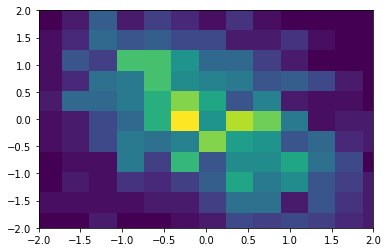

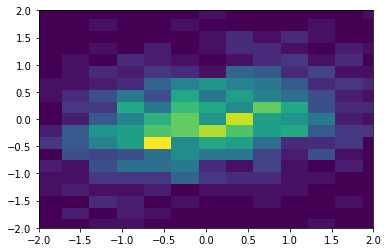

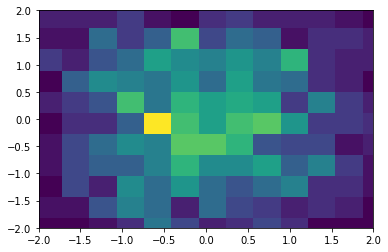

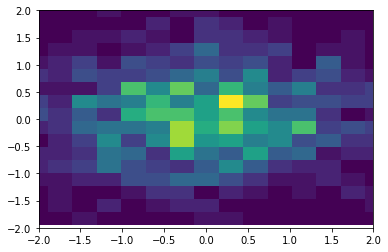

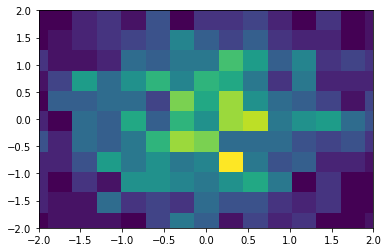

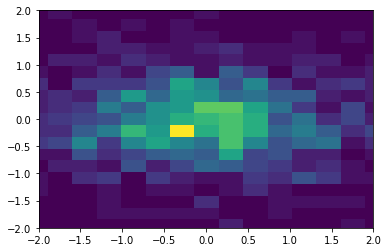

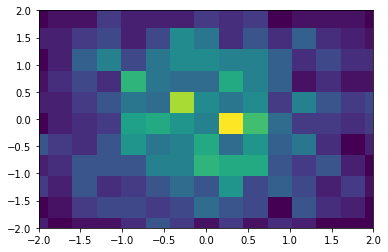

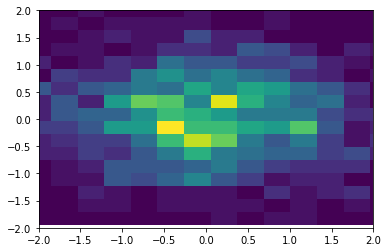

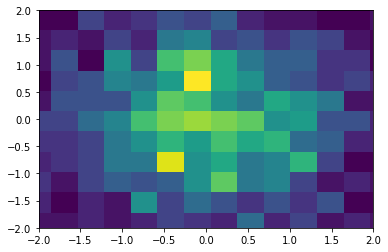

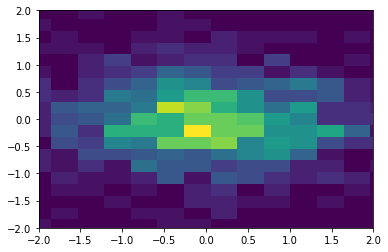

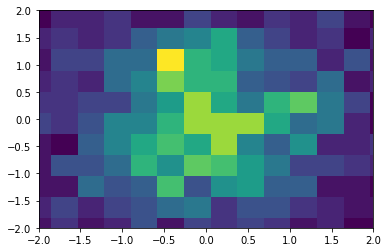

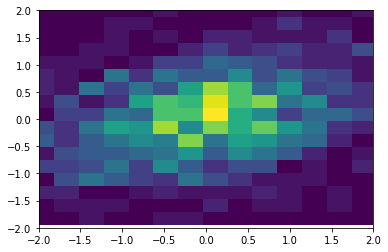

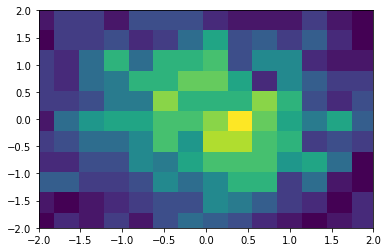

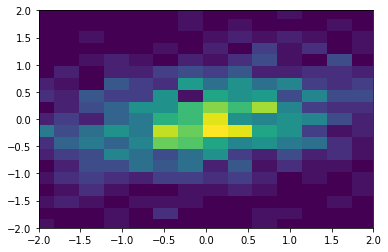

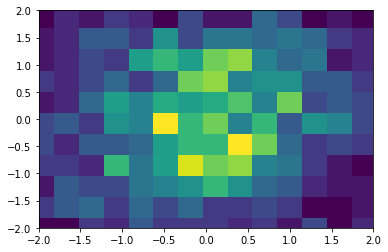

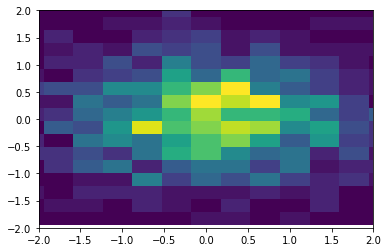

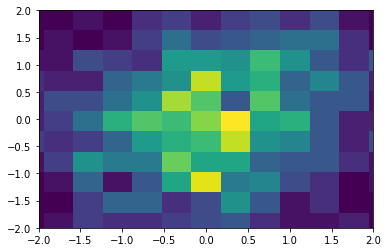

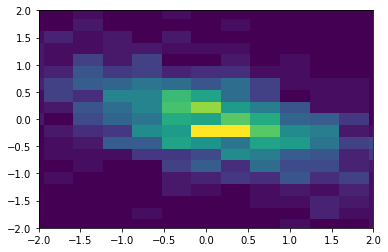

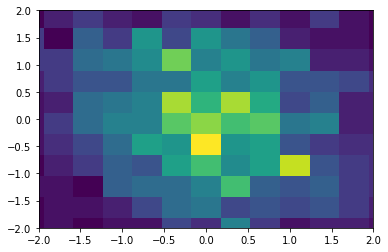

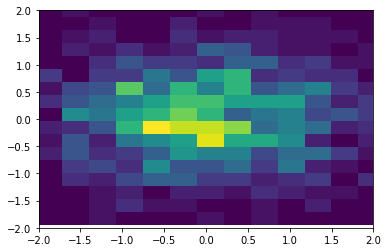

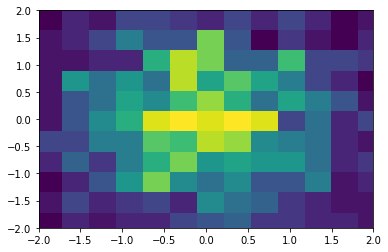

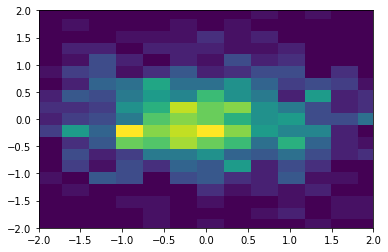

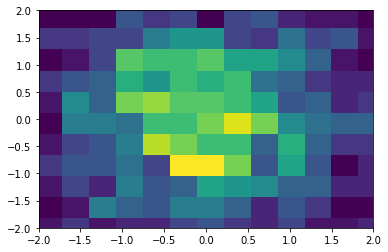

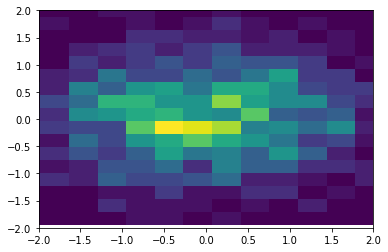

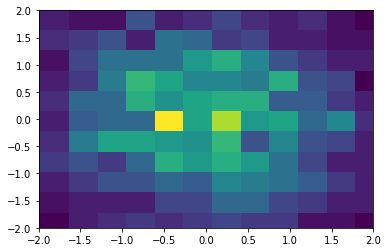

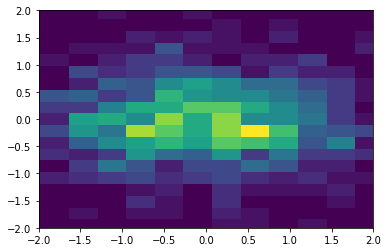

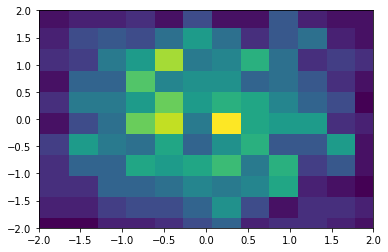

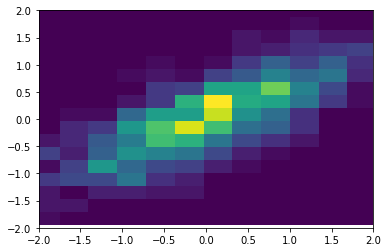

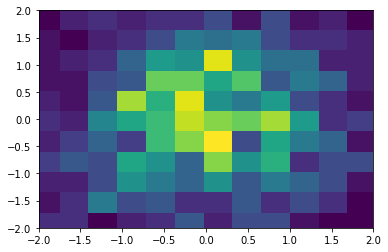

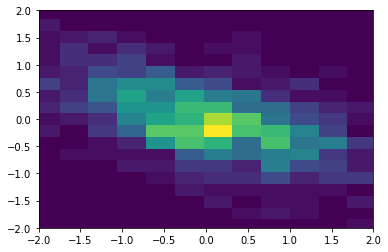

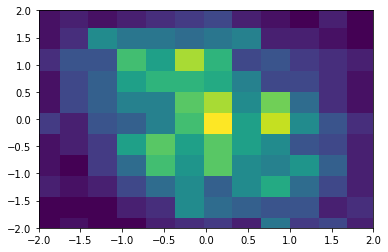

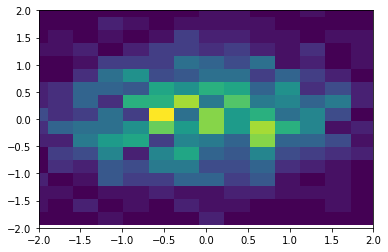

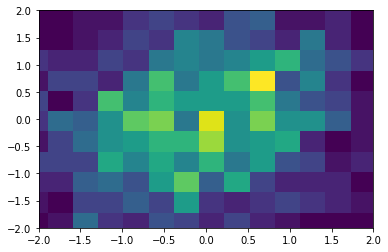

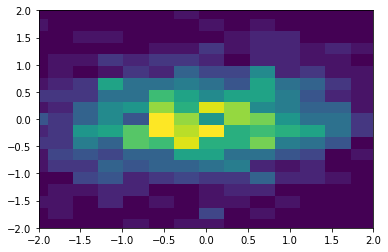

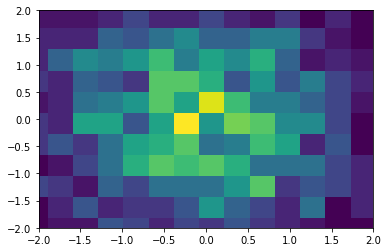

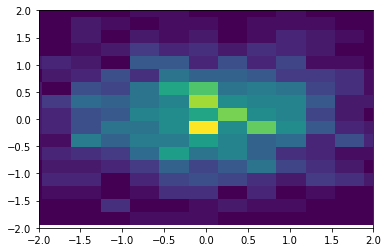

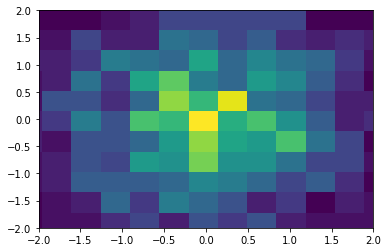

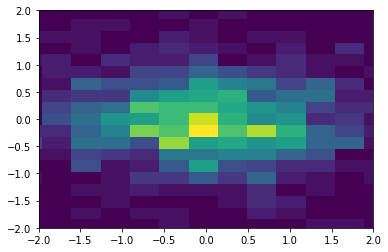

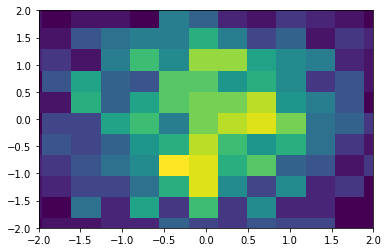

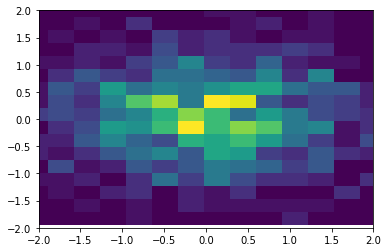

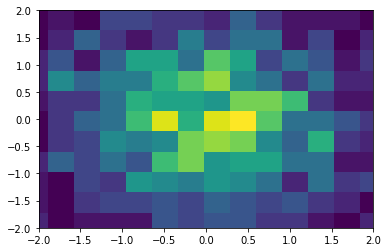

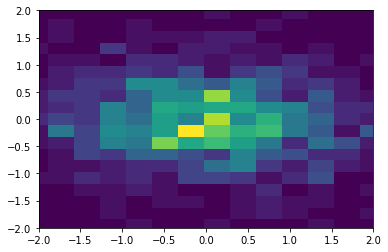

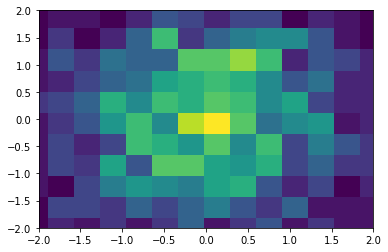

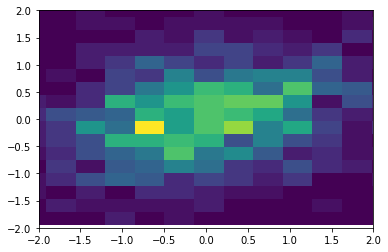

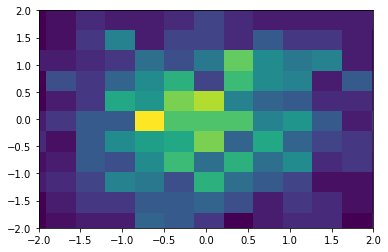

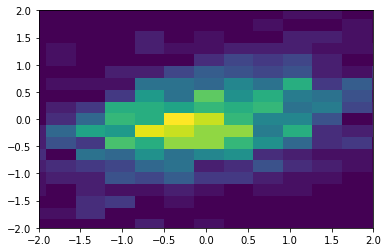

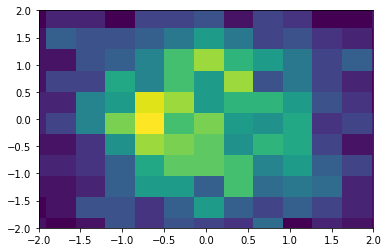

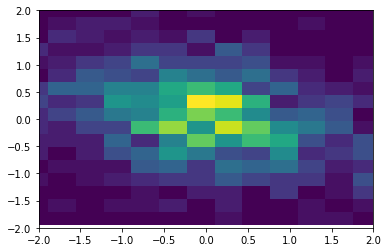

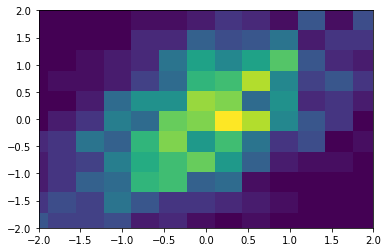

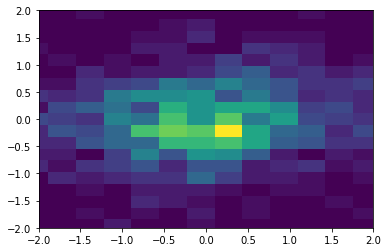

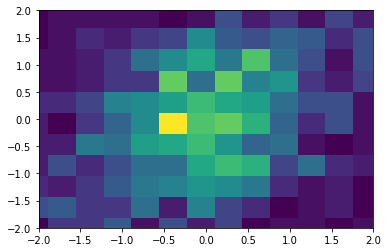

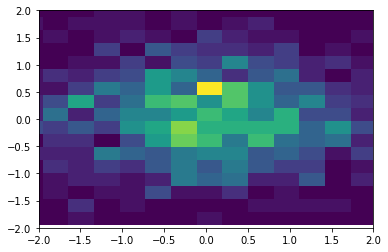

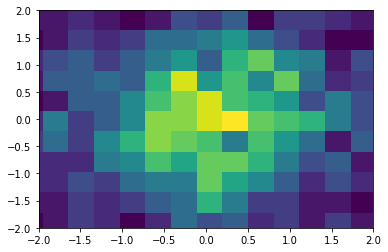

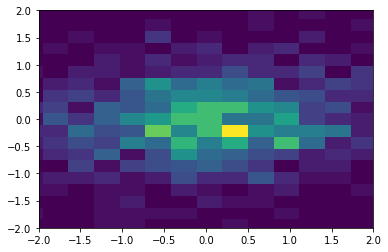

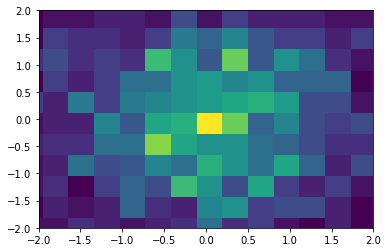

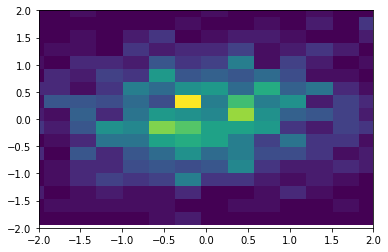

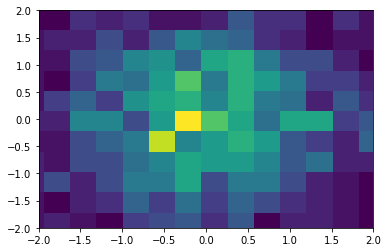

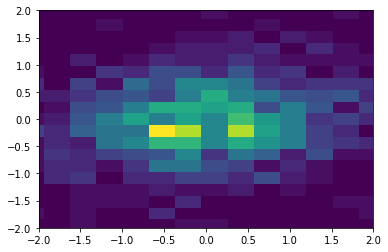

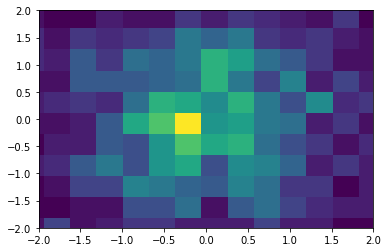

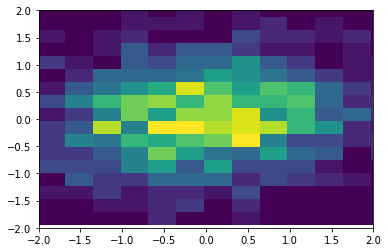

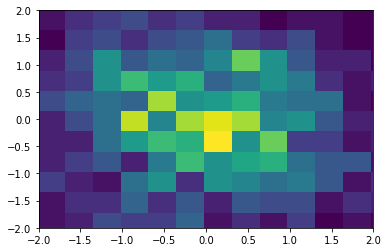

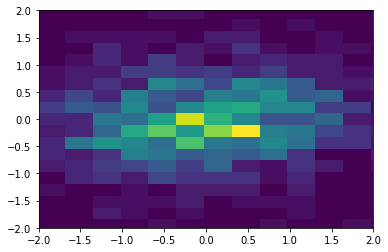

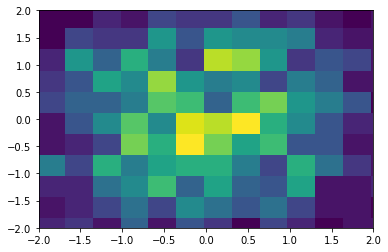

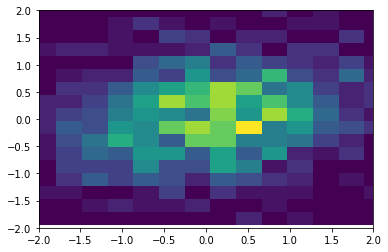

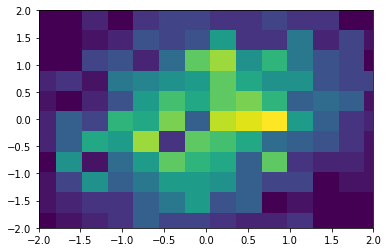

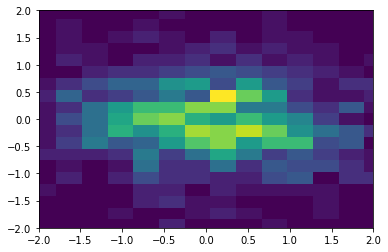

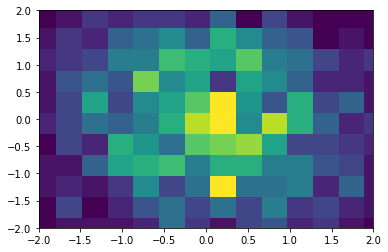

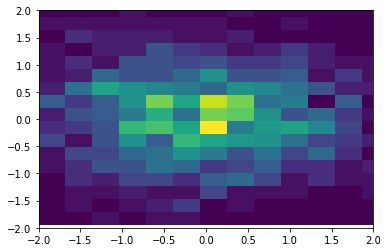

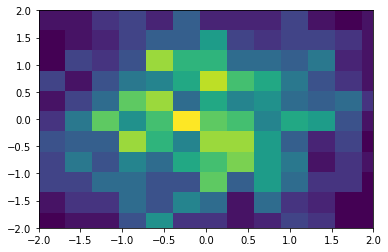

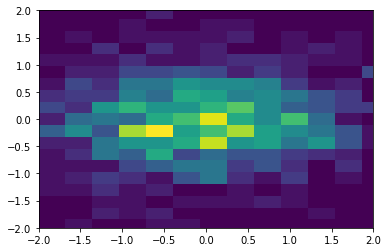

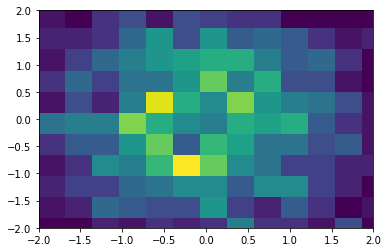

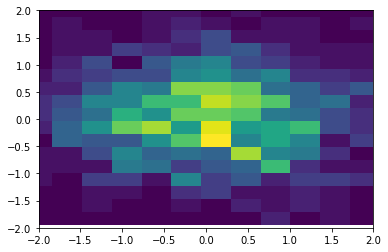

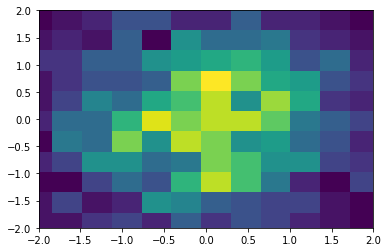

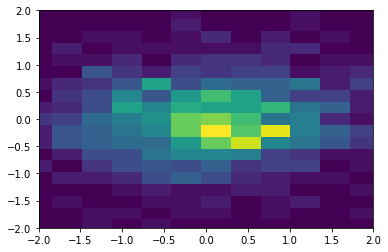

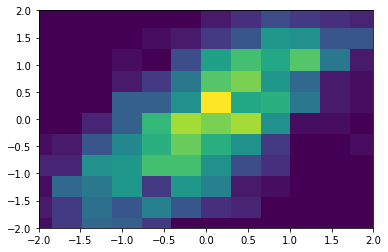

In [19]:
for i in range(5):
    for j in range(4):
        for k in range(4):
            plt.hist2d(random_input[:,i,j],random_output[:,0,k],bins=20);
            plt.xlim(-2,2)
            plt.ylim(-2,2)
            plt.show()

This is not very useful because it's very high dimensional. It's hard to tell what is happening and there are a lot of states that are very low probability.

We want to know the probability of a state. For this we need an encoder and decoder model. 

In [20]:
class CVAE(tf.keras.Model):
  """Convolutional variational autoencoder."""

  def __init__(self):
    super(CVAE, self).__init__()
    self.encoder = tf.keras.Sequential(
        [
            tf.keras.layers.InputLayer(input_shape=(5,4)),
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(20),
            tf.keras.layers.Dense(10,)
        ]
    )

    self.decoder = tf.keras.Sequential(
        [
            tf.keras.layers.InputLayer(input_shape=(5,)),
            tf.keras.layers.Dense(units=20),
            tf.keras.layers.Dense(units=20),
            tf.keras.layers.Reshape(target_shape=(5,4)),
        ]
    )
    self.predictor = tf.keras.Sequential(
        [
            tf.keras.layers.InputLayer(input_shape=(5,)),
            tf.keras.layers.Dense(units=20),
            tf.keras.layers.Dense(units=4),
            tf.keras.layers.Reshape(target_shape=(1,4)),
        ]
    )

  @tf.function
  def sample(self, eps=None):
    if eps is None:
      eps = tf.random.normal(shape=(100, 5))
    return self.decode(eps)

  def encode(self, x):
    mean, logvar = tf.split(self.encoder(x), num_or_size_splits=2, axis=1)
    return mean, logvar

  def reparameterize(self, mean, logvar):
    eps = tf.random.normal(shape=mean.shape)
    return eps * tf.exp(logvar * .5) + mean

  def decode(self, z):
    logits = self.decoder(z)
    return logits

We want to maximize the probability of the inputs. P(x)

A logit is $Q(x) \frac{P(x)}{1-P(x)}$

We want to maximize P(x) and this is greater than or equal to the ELBO loss

OK for lack of knowing how to do this otherwise we will use the KL divergence on the latent output p(z) as the main loss and the MSE on both the autoencoder output and the predictor output

$D_{KL}(Q||P(z))$ where $Q=N(0,1)$

In [124]:
model2 = CVAE()
model2.history = []
optimizer = tf.keras.optimizers.Adam(1e-4)


def log_normal_pdf(sample, mean, logvar, raxis=1):
    log2pi = tf.math.log(2. * np.pi)
    return tf.reduce_sum(
      -.5 * ((sample - mean) ** 2. * tf.exp(-logvar) + logvar + log2pi),
      axis=raxis)


def compute_loss(model, x,y_true):
    mean, logvar = model.encode(x)
    
    z = model.reparameterize(mean, logvar)
    x_prediction = model.decode(z)
    y_prediction = model.predictor(z)
    KL_z = logvar + (tf.exp(logvar)**2 + mean**2)/2 -.5
    logpz = log_normal_pdf(z, 0., 0.)
    logqz_x = log_normal_pdf(z, mean, logvar)
    y_prediction_mse = tf.keras.losses.MSE(y_true,y_prediction)
    x_prediction_mse = tf.keras.losses.MSE(x,x_prediction)
    
    loss = tf.reduce_mean(KL_z) + tf.reduce_mean(y_prediction_mse) + tf.reduce_mean(x_prediction_mse)
    return loss


@tf.function
def train_step(model, data_generator, optimizer):
    """Executes one training step and returns the loss.

    This function computes the loss and gradients, and uses the latter to
    update the model's parameters.
    """
    x,y = next(data_generator)
    with tf.GradientTape() as tape:
        loss = compute_loss(model, x,y)
    
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

In [125]:
x,y = next(data_generator)


In [25]:
data_generator.n = 0

In [26]:
compute_loss(model2,x,y)

<tf.Tensor: shape=(), dtype=float32, numpy=-1.576716>

In [126]:
model2.encode(x)

(<tf.Tensor: shape=(32, 5), dtype=float32, numpy=
 array([[-0.2648841 ,  0.37293398, -0.2516941 ,  0.2860724 , -0.17853333],
        [ 0.23770164,  0.15972891,  0.50892895,  0.25583526, -0.38835827],
        [ 0.11087728, -0.00952093,  0.2761747 , -0.74740124, -2.2383826 ],
        [ 0.3039944 , -0.7653048 , -0.49694404, -0.26222453, -1.62274   ],
        [ 0.5428119 ,  0.01162086,  0.18593732, -0.81520003, -1.3416377 ],
        [-0.19447784, -0.1187805 , -0.02695224,  0.3261547 , -2.2524555 ],
        [-0.14959659, -0.18968426, -0.10236721, -0.19113037, -0.2314995 ],
        [-0.58751476, -0.34486032, -0.1782173 ,  0.13487205,  1.653591  ],
        [-0.4998158 ,  0.43040025,  0.41389057,  0.0804175 , -0.05640063],
        [-0.447975  , -0.41477862, -0.55045784, -0.5883033 ,  2.382668  ],
        [ 0.10650454, -0.26124212, -0.13431495, -0.55619574, -0.15479773],
        [ 0.10747354,  0.2913542 ,  0.37727416,  0.3838269 , -1.2739465 ],
        [ 0.26377234,  0.97498304,  0.47028962, -0

In [104]:
z = model2.reparameterize(*model2.encode(x))

In [108]:
np.isnan(z[0][0].numpy())

False

In [129]:

data_generator.n=0
while data_generator.n<484:
    data_generator.n+=1
    train_step(model2,data_generator,optimizer)
    z = model2.reparameterize(*model2.encode(x))

In [130]:
compute_loss(model2,x,y)

<tf.Tensor: shape=(), dtype=float32, numpy=0.17211318>

In [131]:
z = model2.reparameterize(*model2.encode(x))
print(z)

tf.Tensor(
[[ 1.16916835e-01 -6.12396717e-01  4.98964012e-01  2.05519795e-03
  -9.50686187e-02]
 [ 9.10839558e-01 -8.52156281e-01 -5.07756948e-01 -9.37964857e-01
  -1.90104198e+00]
 [ 7.85562217e-01 -5.52056313e-01 -1.79889452e+00 -4.05891955e-01
  -5.17122149e-01]
 [ 4.98483032e-02 -2.19419837e-01 -7.00580716e-01 -1.19891250e+00
  -1.74648476e+00]
 [ 2.70570457e-01  5.69216132e-01 -2.53709435e-01  5.44956207e-01
  -8.79491985e-01]
 [ 3.78245264e-01 -7.05417514e-01 -6.27460003e-01  1.21175039e+00
  -1.39700913e+00]
 [ 3.06522578e-01 -4.62305516e-01  2.07419693e-01 -2.69627213e-01
  -7.16729522e-01]
 [ 1.10017765e+00 -3.08102012e-01 -9.75620866e-01  1.09973505e-01
   1.18028748e+00]
 [-8.08865190e-01  1.00511432e-01  4.03669715e-01  1.00729060e+00
   6.40290856e-01]
 [-7.05499828e-01 -7.69870400e-01  1.06113172e+00  5.34668982e-01
   1.97655106e+00]
 [-3.71157676e-01  1.29872322e-01 -2.91435659e-01  1.81369781e-02
   4.86407243e-02]
 [ 3.67297113e-01 -1.72381997e+00  5.98513663e-01  2.1

In [139]:
x_predicted = model2.decode(model2.reparameterize(*model2.encode(np.random.randn(1000,5,4))))

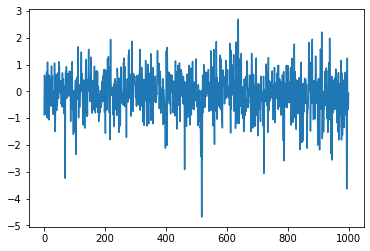

In [145]:
plt.plot(x_predicted[:,-1,3])

In [261]:
model2.decoder(np.random.randn(1,5))

<tf.Tensor: shape=(1, 5, 4), dtype=float32, numpy=
array([[[nan, nan, nan, nan],
        [nan, nan, nan, nan],
        [nan, nan, nan, nan],
        [nan, nan, nan, nan],
        [nan, nan, nan, nan]]], dtype=float32)>

In [109]:
model2 = CVAE()

In [110]:
model2.compile(loss="MSE")

In [111]:
mean,logvar = model2.encode(random_input)

In [105]:
model2.decode(model2.reparameterize(mean,logvar)).shape

TensorShape([1000, 1, 4])

In [ ]:
num_steps_input = 5
num_steps_output = 1
model_input = tf.keras.Input(shape=(5,4))

y = tf.keras.layers.Flatten()(model_input)
y = tf.keras.layers.Dense(10)(y)
y = tf.keras.layers.Dense(4*2)(y)

y = tf.keras.layers.Dense(4*num_steps_output)(y)
y = tf.keras.layers.Reshape((num_steps_output,4))(y)

model = tf.keras.Model(inputs = model_input,outputs = y)

No handles with labels found to put in legend.


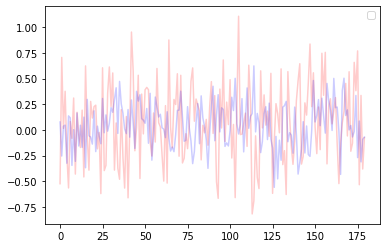

In [17]:
I = 2
for i in range(I,I+1):
    if i==0:
        plt.plot(D[-L-6:-20][:,i],c="r",alpha=.2,label="real")
        plt.plot(A[:,:,i][::32],c="b",alpha=.2,label="predicted")
    else:
        plt.plot(D[-L-6:-20][:,i],c="r",alpha=.2)
        plt.plot(A[:,:,i][::32],c="b",alpha=.2)
plt.legend()

### Now we want the model to return the output as it's training. Every step should be a training step. But it should also be a step that tells you something about the future.

In [18]:
class ModelWithOutput(tf.keras.Model):
    def train_step(self, data):
        # Unpack the data. Its structure depends on your model and
        # on what you pass to `fit()`.
        x, y = data

        with tf.GradientTape() as tape:
            y_pred = self(x, training=True)  # Forward pass
            # Compute the loss value
            # (the loss function is configured in `compile()`)
            loss = self.compiled_loss(y, y_pred, regularization_losses=self.losses)

        # Compute gradients
        trainable_vars = self.trainable_variables
        gradients = tape.gradient(loss, trainable_vars)
        # Update weights
        self.optimizer.apply_gradients(zip(gradients, trainable_vars))
        # Update metrics (includes the metric that tracks the loss)
        self.compiled_metrics.update_state(y, y_pred)
        # Return a dict mapping metric names to current value
        out = {m.name: m.result() for m in self.metrics}
        out['prediction'] = y_pred
        return out

In [21]:
A[::32]

array([[[ 6.43825173e-01,  1.66819423e-01,  7.72754624e-02,
         -4.40287501e-01]],

       [[-4.38225359e-01, -2.27366626e-01, -2.54059017e-01,
         -7.83222198e-01]],

       [[-7.57263660e-01, -2.99118757e-01,  3.65685895e-02,
         -1.23767927e-01]],

       [[-8.24525654e-02, -4.01829362e-01,  4.68307808e-02,
         -1.15207946e+00]],

       [[-4.12229031e-01, -1.84964657e-01, -3.24228495e-01,
          7.28154659e-01]],

       [[ 1.86843142e-01, -6.28788099e-02,  1.36589378e-01,
         -4.45926785e-01]],

       [[ 6.02777824e-02, -1.19248956e-01,  1.17849462e-01,
          1.52219534e-01]],

       [[-3.75379294e-01,  1.45457387e-02, -3.45164955e-01,
          4.50066417e-01]],

       [[-6.07366085e-01, -4.87518877e-01,  2.56899931e-03,
         -2.51936346e-01]],

       [[-7.78840482e-02, -4.37629640e-01, -3.05561870e-01,
          1.41237408e-01]],

       [[-3.67989540e-01, -1.78916410e-01,  1.64702758e-01,
          8.05204272e-01]],

       [[-8.77514780e